<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250125%5D%20Hybrid%20LR-BiLSTM%20on%20UNSW-NB15%20with%20Adaptive%20Attack%20Simulations%20(100Ep).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid LR-Bi-LSTM for 10 class classifications based on UNSW-NB15 dataset**

In [ ]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 4.9 MB/s eta 0:00:00


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.utils import to_categorical
from keras.regularizers import l2
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
dataset = pd.read_csv("Dataset_10Classes.csv")

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,ID_Cb,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,Class
0,1,1,0.121478,tcp,-,FIN,6,4,258,172,...,1,0,0,0,1,1,0,Normal,0,0
1,2,2,0.649902,tcp,-,FIN,14,38,734,42014,...,2,0,0,0,1,6,0,Normal,0,0
2,3,3,1.623129,tcp,-,FIN,8,16,364,13186,...,3,0,0,0,2,6,0,Normal,0,0
3,4,4,1.681642,tcp,ftp,FIN,12,12,628,770,...,3,1,1,0,2,1,0,Normal,0,0
4,5,5,0.449454,tcp,-,FIN,10,6,534,268,...,40,0,0,0,2,39,0,Normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,257669,82328,0.000005,udp,-,INT,2,0,104,0,...,2,0,0,0,2,1,0,Normal,0,0
257669,257670,82329,1.106101,tcp,-,FIN,20,8,18062,354,...,1,0,0,0,3,2,0,Normal,0,0
257670,257671,82330,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0
257671,257672,82331,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0


### **Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [93000  2677  2329 16353 44525 24246 58871 13987  1511   174]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the data
#smote = SMOTE(random_state=42)
#X_balanced, y_balanced = smote.fit_resample(X, y)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [93000 93000 93000 93000 93000 93000 93000 93000 93000 93000]


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **Hybrid combination of LR-Bi-LSTM for 10 class classifications on UNSW-NB15**

**Hybrid model with using features results from LR model as Bi-LSTM input**

In [ ]:
from keras.utils import to_categorical

# Train Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Extract LR probabilities for Bi-LSTM input
train_lr_features = lr_model.predict_proba(X_train)
test_lr_features = lr_model.predict_proba(X_test)
train_lr_features = np.expand_dims(train_lr_features, axis=1)
test_lr_features = np.expand_dims(test_lr_features, axis=1)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(np.unique(y)))
y_test = to_categorical(y_test, num_classes=len(np.unique(y)))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
!pip install tensorflow #Ensure TensorFlow is installed

In [ ]:
import tensorflow as tf

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.utils import to_categorical
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully uninstalled tensorflow-2.14.0
ERROR: pip's dependency resol

In [ ]:
#from keras.regularizers import l2

# Define the Bi-LSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))),
    Dropout(0.2),
    Dense(len(np.unique(y)), activation='softmax', kernel_regularizer=l2(0.0001))
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Bi-LSTM model
start_time = time.time()
history = bilstm_model.fit(train_lr_features, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=1)
end_time = time.time()

# Evaluate on test set
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
print("\nHybrid Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, test_predictions_labels))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9300/9300 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.9942 - loss: 0.1839 - val_accuracy: 0.9999 - val_loss: 0.0167
Epoch 2/100
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9999 - loss: 0.0166 - val_accuracy: 0.9999 - val_loss: 0.0145
Epoch 3/100
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9999 - loss: 0.0150 - val_accuracy: 0.9999 - val_loss: 0.0142
Epoch 4/100
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9999 - loss: 0.0148 - val_accuracy: 0.9999 - val_loss: 0.0142
Epoch 5/100
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9999 - loss: 0.0148 - val_accuracy: 0.9999 - val_loss: 0.0141
Epoch 6/100
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9999 - loss: 0.0147 - val_accuracy: 0.9999 - val_loss: 0.0141
Epoch 7/100
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9999 - loss: 0.0147 - val_accuracy: 0.9999 - val_loss: 0.0140
Epoch 8/100
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9999 - loss: 0.014

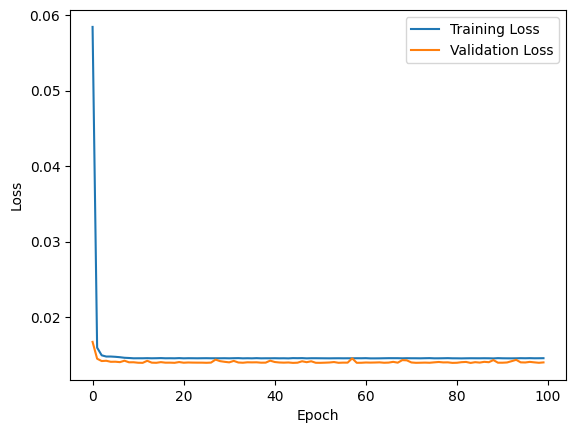

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')

print("\nHybrid Model Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1)


Hybrid Model Accuracy: 0.9998924731182796

Precision: 0.9998924846622831

Recall: 0.9998924731182797

F1-Score: 0.9998924667537231


In [ ]:
# Analyze training time
print(f"Training Time: {end_time - start_time:.2f} seconds")

Training Time: 3670.80 seconds


In [ ]:
# --- Adaptive Attack Simulations ---
def generate_adaptive_attack(model, data, labels, epsilon=0.1):
    """Simulates adaptive adversarial attacks by iteratively adjusting perturbations."""
    adversarial_data = tf.convert_to_tensor(data, dtype=tf.float32) # Convert data to TensorFlow Tensor
    for i in range(3):  # Simulate multi-step attack
        with tf.GradientTape() as tape:
            tape.watch(adversarial_data)
            predictions = model(adversarial_data)
            loss = tf.keras.losses.categorical_crossentropy(labels, predictions)
        gradients = tape.gradient(loss, adversarial_data)
        perturbations = epsilon * tf.sign(gradients)
        adversarial_data = adversarial_data + perturbations # Use TensorFlow operations
        adversarial_data = tf.clip_by_value(adversarial_data, 0, 1)  # Keep data in valid range
    return adversarial_data.numpy()

# Generate adaptive adversarial examples for testing
adaptive_adversarial_test = generate_adaptive_attack(bilstm_model, test_lr_features, y_test)

# Evaluate model on adaptive adversarial examples
adaptive_test_predictions = bilstm_model.predict(adaptive_adversarial_test)
adaptive_test_predictions_labels = np.argmax(adaptive_test_predictions, axis=1)
adaptive_accuracy = accuracy_score(true_labels, adaptive_test_predictions_labels)

print("\nModel Accuracy under Adaptive Attack:", adaptive_accuracy)
print("\nClassification Report for Adaptive Attack:")
print(classification_report(true_labels, adaptive_test_predictions_labels))

5813/5813 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step

Model Accuracy under Adaptive Attack: 0.8972043010752688

Classification Report for Adaptive Attack:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18600
           1       1.00      1.00      1.00     18600
           2       1.00      1.00      1.00     18600
           3       1.00      1.00      1.00     18600
           4       1.00      1.00      1.00     18600
           5       0.00      0.00      0.00     18600
           6       0.49      0.98      0.66     18600
           7       1.00      1.00      1.00     18600
           8       0.99      1.00      0.99     18600
           9       1.00      1.00      1.00     18600

    accuracy                           0.90    186000
   macro avg       0.85      0.90      0.86    186000
weighted avg       0.85      0.90      0.86    186000



In [ ]:
# --- Latency and Resource Analysis ---
import psutil
import os

# Measure memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB
print(f"Memory Usage: {memory_usage:.2f} MB")

Memory Usage: 7741.99 MB


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18600
           1       1.00      1.00      1.00     18600
           2       1.00      1.00      1.00     18600
           3       1.00      1.00      1.00     18600
           4       1.00      1.00      1.00     18600
           5       1.00      1.00      1.00     18600
           6       1.00      1.00      1.00     18600
           7       1.00      1.00      1.00     18600
           8       1.00      1.00      1.00     18600
           9       1.00      1.00      1.00     18600

    accuracy                           1.00    186000
   macro avg       1.00      1.00      1.00    186000
weighted avg       1.00      1.00      1.00    186000



In [ ]:
# Detection Rate (Recall for each class)
detection_rate = recall_score(true_labels, test_predictions_labels, average=None)
for i in range(len(detection_rate)):
    print(f"Detection Rate for Class {i}: {detection_rate[i]:.15f}")

Detection Rate for Class 0: 1.000000000000000
Detection Rate for Class 1: 1.000000000000000
Detection Rate for Class 2: 1.000000000000000
Detection Rate for Class 3: 1.000000000000000
Detection Rate for Class 4: 1.000000000000000
Detection Rate for Class 5: 0.999892473118280
Detection Rate for Class 6: 0.999193548387097
Detection Rate for Class 7: 0.999838709677419
Detection Rate for Class 8: 1.000000000000000
Detection Rate for Class 9: 1.000000000000000


**With FGSM adversarial training**

In [ ]:
import tensorflow as tf
from keras.regularizers import l2

#Build the Bi-LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))))
bilstm_model.add(Dropout(0.2))
#bilstm_model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))))
#bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(9, activation='softmax', kernel_regularizer=l2(0.0001)))

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# FGSM: Function to generate adversarial examples
def generate_adversarial_examples(model, data, labels, epsilon=0.1):
    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(data_tensor)
        predictions = model(data_tensor)
        loss = tf.keras.losses.categorical_crossentropy(labels_tensor, predictions)

    gradients = tape.gradient(loss, data_tensor)
    perturbations = epsilon * tf.sign(gradients)
    adversarial_data = data_tensor + perturbations

    return adversarial_data.numpy()

# Generate adversarial examples for training
adversarial_train_features = generate_adversarial_examples(bilstm_model, train_lr_features, y_train)

# Combine original and adversarial examples
combined_train_features = np.concatenate((train_lr_features, adversarial_train_features), axis=0)
combined_train_labels = np.concatenate((y_train, y_train), axis=0)

# Train the Bi-LSTM model
history = bilstm_model.fit(
    combined_train_features, combined_train_labels,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Metrics and results
accuracy = accuracy_score(true_labels, test_predictions_labels)
print("\nHybrid Model Accuracy with FGSM:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, test_predictions_labels))

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')

print("\nHybrid Model Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1)

In [ ]:
# Detection Rate (Recall for each class)
detection_rate = recall_score(true_labels, test_predictions_labels, average=None)
for i in range(len(detection_rate)):
    print(f"Detection Rate for Class {i}: {detection_rate[i]:.10f}")